In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from datetime import tzinfo
from time import timezone

from tensorflow.keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler

In [2]:
"""
The goal in this section is to open Tata Global Beverages Limited stock 
value.
"""
df = pd.read_csv("NSE-TATA.csv")
df.head()



,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


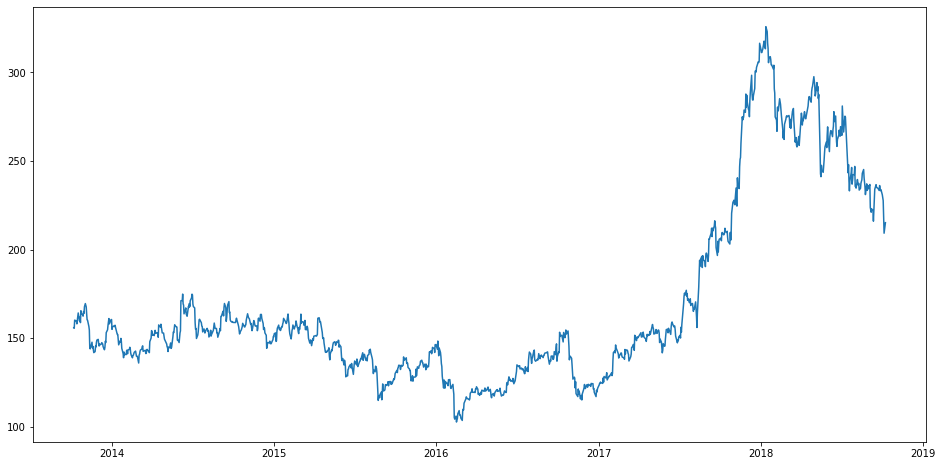

In [3]:
"""
The goal in this section is to create a graph that let us analyse the
closing prices.
"""

#The current date column looks like it's in pd datetime, but it's a string.



df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
#df["Date"].map(lambda dt: dt.timestamp())
#df['Date'] = df['Date'].str.replace('-', '')
#df["Date"] = df["Date"].astype(int)
df.index=df['Date']

#Create the figure for analysis with a width of 16, height 8.
plt.figure(figsize=(16,8))
#plot our graph with y axis as the close value, and x axis as index (date)
plt.plot(df["Close"],label='Close Price history')



In [4]:
"""
The goal here is to sort our dataset with the datetime and set them into a 
new dataset. This dataset only has the date and closing value of the stock
"""
#sort our dataframe along each rows (Datetime) and assign that to data
data = df.sort_index(ascending = True, axis = 0)

#Create na new dataframe With Date and Close (closing value) as columns
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

#Convert our Date and Close in Daa into new_dataset
for i in range(0,len(data)):
    #Assign the ith position of Date/Close to the ith position in data
    new_dataset["Date"][i]=data["Date"][i]
    new_dataset["Close"][i]=data["Close"][i]



In [5]:
"""
Normalise the training data so that they all have the
same format. Also filter these data into training,
validation, as well as it's x and y component
"""
#scaler=MinMaxScaler(feature_range=(0,1))

new_dataset['Date'] = df.Date.astype('int64') // 10**9

#return the values of new_dataset in nested list
final_dataset=new_dataset.values

#The training and validation component of dataset
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

#scaler can transform all given input into (0, 1)
scaler=MinMaxScaler(feature_range=(0,1))

#Transform our dataset into the range of (0,1)
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

#Append our scaled data into 
for i in range(60,len(train_data)):

    #We need to cover 60-timestamp for the RNN to predict the 61st price. 
    #So x_train is nested each containing 60-time stamp prices
    x_train_data.append(scaled_data[i-60:i,0])

    #y_train contains the stock price everyday which is the stock price 
    #corresponding to reach list in x_train.
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

#reshape into (x_train_data.shape[0],x_train_data.shape[1], 1) -> (927,60,1)
#This is in the form (batch size, number of timestamp, number of key features)
x_train_data=np.reshape(x_train_data,
    (x_train_data.shape[0],x_train_data.shape[1],1))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [6]:
"""
Building the long short term memmory model for our model to memorise 
things and apply it to prediction.
"""

#The sequential model allows a linear stack of layers
lstm_model = Sequential(
    [
    #The output is 50 unit, and return the full sequence. 
    LSTM(units=50,return_sequences=True, input_shape = (x_train_data.shape[1],1)),
    LSTM(units=50),
    #Dense makes it so all neruron recieves input from neurons in the previous layer
    #Unit is 1, since we only have 1 prediction.
    Dense(1)
    ]
)

lstm_model.summary()


2022-08-13 17:06:01.206024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [7]:
"""
Compiling our model and training it
"""

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 20s - loss: nan - 20s/epoch - 22ms/step


In [22]:
"""
The input_data is the data that we want the model to predict.
"""
#The data that the model havn't seen before, and make predictions on them.
#Grab the total dataset minus out the validation dataset, and minus out the 60 training timestamp.
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values

#reshape it and transform it into our (0, 1) range
inputs_data=scaler.transform(inputs_data)

In [24]:
"""
Making the stock prediction now
"""
X_test=[]

#Append our input data into our test now
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])

#Turn our testing set into a nparray and reshape it into required format.
X_test=np.array(X_test)
#Test has 248 list, each list has 60 timestamp, and each timestamp has 1 price)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

#Make prediction
predicted_closing_price=lstm_model.predict(X_test)
#predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 [==============================] - 0s 22ms/step


In [25]:
lstm_model.save("saved_model.h5")

/var/folders/6h/k5t3mkks6150835ytw73t_mh0000gn/T/ipykernel_6160/107833647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


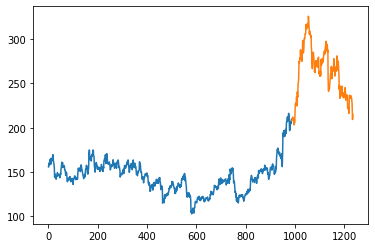

In [26]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])